Number of Rows: 53515
Number of Columns: 84
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 300}
Best Cross-Validation Accuracy: 0.8115590237874301
Test Accuracy (Default Threshold): 0.823917782622236
AUC-ROC: 0.9076242135435927
AUC-PR: 0.855121155079178
Test Accuracy (Adjusted Threshold): 0.8206166303332295


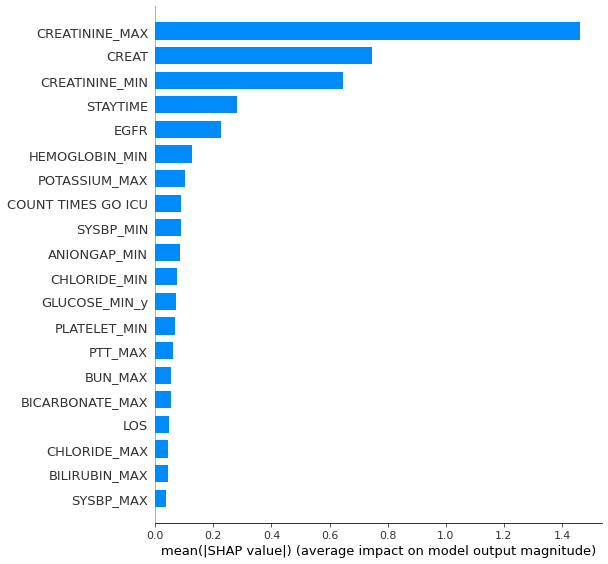

Top 5 Features by SHAP Importance:
           Feature  SHAP_Importance
17  CREATININE_MAX         1.462742
5            CREAT         0.744409
16  CREATININE_MIN         0.647168
0         STAYTIME         0.280579
4             EGFR         0.225320
✅ Model saved successfully!
✅ Threshold saved successfully!
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['STAYTIME', 'AGE', 'LOS', 'COUNT TIMES GO ICU', 'EGFR', 'CREAT',
       'ANIONGAP_MIN', 'ANIONGAP_MAX', 'ALBUMIN_MIN', 'ALBUMIN_MAX',
       'BANDS_MIN', 'BANDS_MAX', 'BICARBONATE_MIN', 'BICARBONATE_MAX',
       'BILIRUBIN_MIN', 'BILIRUBIN_MAX', 'CREATININE_MIN', 'CR...
       'DIABETES_UNCOMPLICATED', 'DIABETES_COMPLICATED', 'HYPOTHYROIDISM',
       'LIVER_DISEASE', 'OBESIT

In [1]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
import numpy as np
import joblib
import shap
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score

# Load data
data = pd.read_csv("Data/analysis_without_urine_aki.csv")
print("Number of Rows:", data.shape[0])
print("Number of Columns:", data.shape[1])

# Prepare features and target
X = data.drop('AKI_7DAY', axis=1)
y = data['AKI_7DAY']

# Replace infinities with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numeric_cols = X.select_dtypes(include=['number']).columns

# Create transformers for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))  # Impute missing values with the mean
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Impute missing values with 'missing'
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Apply one-hot encoding
])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define the pipeline with preprocessor and classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Define hyperparameter grid
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1]
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(
    estimator=pipeline, 
    param_grid=param_grid, 
    cv=3, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=2  # Shows progress
)

# Fit Grid Search on the raw data
grid_search.fit(X_train, y_train)

# Print best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate on the test set
y_pred = grid_search.predict(X_test)
y_proba = grid_search.predict_proba(X_test)[:, 1]  # Get AKI probability

# Adjust threshold for classification
threshold = 0.40  # Lower the threshold to improve sensitivity
y_pred_adjusted = (y_proba > threshold).astype(int)

print("Test Accuracy (Default Threshold):", accuracy_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_proba))
print("AUC-PR:", average_precision_score(y_test, y_proba))
print("Test Accuracy (Adjusted Threshold):", accuracy_score(y_test, y_pred_adjusted))

# Get the best model
best_model = grid_search.best_estimator_

# Use SHAP to explain the model's predictions
explainer = shap.TreeExplainer(best_model.named_steps['classifier'])
shap_values = explainer.shap_values(best_model.named_steps['preprocessor'].transform(X_train))

# Get feature names after preprocessing
numeric_feature_names = numeric_cols.tolist()
categorical_feature_names = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols).tolist()
feature_names = numeric_feature_names + categorical_feature_names

# Summarize SHAP values for feature importance
shap.summary_plot(shap_values, best_model.named_steps['preprocessor'].transform(X_train), feature_names=feature_names, plot_type="bar")

# Get the mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'SHAP_Importance': mean_abs_shap_values
})

# Sort by SHAP importance and get the top 5 features
top_10_features = feature_importance_df.sort_values(by='SHAP_Importance', ascending=False).head(10)
print("Top 10 Features by SHAP Importance:")
print(top_10_features)

# Save the best model
joblib.dump(best_model, 'Model/aki_prediction_model.pkl')
print("Model saved successfully!")

# Save adjusted threshold
joblib.dump(threshold, 'Model/threshold.pkl')
print("Threshold saved successfully!")

print(best_model)
print("Number of trees:", best_model.named_steps['classifier'].n_estimators)
print("Max depth:", best_model.named_steps['classifier'].max_depth)


In [27]:
# Load the trained model and imputation values
model = joblib.load("Model/aki_prediction_model.pkl")
default_values = joblib.load("Model/default_values.pkl")

# Extract top 10 SHAP features from previous analysis
top_10_features = feature_importance_df.sort_values(by='SHAP_Importance', ascending=False).head(10)["Feature"]




In [28]:
# sanity check
# Generate a high-risk synthetic AKI-positive sample
synthetic_data = {
    "CREATININE_MAX": 12.0,  # Very high creatinine
    "CREAT": 0.0,  # High serum creatinine
    "CREATININE_MIN": 7.0,  # Elevated baseline creatinine
    "STAYTIME": 10,  # Long hospital stay (critical case)
    "EGFR": 15.0,  # Critically low GFR
    "HEMOGLOBIN_MIN": 6.0,  # Severe anemia
    "POTASSIUM_MAX": 8.5,  # Dangerous hyperkalemia
    "COUNT TIMES GO ICU": 5,  # Multiple ICU admissions
    "SYSBP_MIN": 40,  # Hypotensive (severe kidney distress)
    "ANIONGAP_MIN": 25  # High anion gap (metabolic acidosis)
}

# Convert synthetic data to DataFrame
synthetic_df = pd.DataFrame([synthetic_data])

# Fill missing features with default values (mean for numeric, mode for categorical)
for feature, value in default_values.items():
    if feature not in synthetic_df.columns:
        synthetic_df[feature] = value  # Apply imputed value

# Ensure feature order matches training
synthetic_df = synthetic_df[model.feature_names_in_]

prediction = model.predict(synthetic_df)
probability = model.predict_proba(synthetic_df)[0][1]  # Ensure correct probability extraction
print("Predict_proba output:", model.predict_proba(synthetic_df)[0])
# Ensure probability is correctly formatted
aki_probability_percent = round(probability * 100, 2)  # Convert to percentage

# Display results
{
    "AKI_Prediction": int(prediction[0]),  # Convert to integer (0 or 1)
    "AKI_Probability (%)": aki_probability_percent  # Ensure correct formatting
}


Predict_proba output: [0.0841518 0.9158482]


{'AKI_Prediction': 1, 'AKI_Probability (%)': 91.58}